In [24]:

import argparse
import os
import torch
import numpy as np
import random
import wandb
import models
import yaml
from trainer import Trainer
import pprint
from torchvision import transforms
import datasets


np.random.seed(0)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [25]:
# Load YAML config
with open("./configs/noisycifar3/train_noisycifar3_ce_symm50_vehicle.yaml", 'r') as file:
    config = yaml.safe_load(file)

# # read YAML file from string
# config = yaml.safe_load(
# """
# data:
#   dataset: noisy_cifar3
#   noise_rate: 0.5
#   class_type: animal

# model:
#   architecture: resnet18
#   num_classes: 3

# wandb:
#   mode: disabled # "disabled" or "online"
#   entity: siit-iitp
#   project: noisy-label
#   name: NoisyCIFAR3(symm,0.2,animal)-CE
#   save_code: true

# trainer:
#   optimizer: sgd
#   init_lr: 1.0e-1
#   momentum: 0.9
#   weight_decay: 1.0e-4
#   lr_scheduler: multistep
#   max_epoch: 200
#   loss_fn: cross_entropy
#   num_workers: 2
#   batch_size: 128
#   save_model: true
# """
# )

model = models.get_model(**config["model"]).cuda()
model = torch.jit.script(model)


# WANDB_RUN_ID = "bpfqpr28" # NoisyCIFAR3(symm,0.2,animal)-CE
# WANDB_RUN_ID = "havhjsg5" # NoisyCIFAR3(symm,0.2,vehicle)-CE
# WANDB_RUN_ID = "exudjjy6" # NoisyCIFAR3(symm,0.5,animal)-CE
# WANDB_RUN_ID = "mwmu8jyc" # NoisyCIFAR3(symm,0.5,vehicle)-CE
# WANDB_RUN_ID = "hg1w7upv" # NoisyCIFAR3(symm,0.8,animal)-CE
WANDB_RUN_ID = "pwsxqo0y" # NoisyCIFAR3(symm,0.8,vehicle)-CE

def load_checkpoint(name="model_199.pth"):
    checkpoint = wandb.restore(name, run_path=f"siit-iitp/noisy-label/{WANDB_RUN_ID}", replace=True)
    model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))

load_checkpoint(name="model_199.pth")


trainer = Trainer(
                model=model,
                config=config['trainer'],
                )

print(trainer.criterion)

CrossEntropyLoss()


## Visualization of perturbed outputs

In [26]:
# perturbation-based filtering
# TODO: 다른 weight로도 두세번 더 돌려보기!

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F
import tqdm.auto as tqdm


import random
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])

auto_augment = AutoAugment(AutoAugmentPolicy.CIFAR10)
num_augment = 100

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1)),
    transforms.Lambda(lambda x: torch.stack([x] + [auto_augment(x) for _ in range(num_augment)], dim=0)), # (11, C, H, W)
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train

dataloader = trainer.get_dataloader(train_dataset, train=False)
dataloader.num_workers = 8

load_checkpoint(f"model_199.pth")

with torch.no_grad():
    trainer.model.eval()
    result = {
        'output': [],
        'loss': [],
        'std': [],
        'mean': [],
        'target': [],
        'target_gt': [],
    }
    for i, batch in enumerate(dataloader):
        data = batch["image"].cuda() # (B, 11, 3, 32, 32)
        target = batch["target"].cuda()[:, None].repeat(1, data.size(1)) # (B, 11)
        target_gt = batch["target_gt"].cuda() # (B,)

        b = data.size(0)
        output = trainer.model(data.view(-1,3,32,32)) # (B*11, 10)

        loss = trainer.criterion(output, target.view(-1)).view(b, -1) # (B, 11)
        raw_loss, aug_loss = loss[:, 0], loss[:, 1:]
        std, mean = torch.std_mean(aug_loss, dim=-1)

        result['output'].append(output.view(b, -1, 3))
        result['loss'].append(raw_loss)
        result['std'].append(std)
        result['mean'].append(mean)
        result['target'].append(target[:, 0])
        result['target_gt'].append(target_gt)

    result = {k: torch.cat(v, dim=0).cpu() for k, v in result.items()}

pprint.pprint(result)

Files already downloaded and verified
Files already downloaded and verified
{'loss': tensor([0.0001, 0.0780, 0.0280,  ..., 0.0575, 0.0031, 0.0002]),
 'mean': tensor([1.0054, 2.8607, 1.1834,  ..., 2.2143, 1.0599, 0.9583]),
 'output': tensor([[[-2.3062,  6.9118, -4.4241],
         [-2.3062,  6.9118, -4.4241],
         [ 4.4599, -0.7402, -3.6401],
         ...,
         [-5.7322,  3.7277,  2.1579],
         [-2.3062,  6.9118, -4.4241],
         [ 2.1312,  6.2832, -8.2814]],

        [[-2.6337,  0.0829,  2.6593],
         [ 1.5419, -0.0326, -1.4467],
         [-0.2454, -2.4314,  2.7777],
         ...,
         [ 1.5419, -0.0326, -1.4467],
         [ 6.6550, -4.2778, -2.2882],
         [-1.1721,  0.1459,  1.1160]],

        [[-4.4830,  4.1026,  0.5350],
         [-1.6901,  4.9853, -3.1300],
         [-4.4830,  4.1026,  0.5350],
         ...,
         [-4.4830,  4.1026,  0.5350],
         [-4.4830,  4.1026,  0.5350],
         [-4.4830,  4.1026,  0.5350]],

        ...,

        [[-0.5361, -1

In [29]:
import pandas as pd

df = pd.DataFrame({
    'pointpred': torch.unbind(result['output'][:,0,:]), # (50000, 10)
    'output': torch.unbind(result['output'][:,1:,:]), # (50000, 10, 10)
    'is_noisy': (result['target'] != result['target_gt']).tolist(), # (50000, 11, 10)
    'target': result['target'].tolist(), # (50000,)
    'target_gt': result['target_gt'].tolist(), # (50000,)
    })

df

,pointpred,output,is_noisy,target,target_gt
0,"[tensor(-2.3062), tensor(6.9118), tensor(-4.42...","[[tensor(-2.3062), tensor(6.9118), tensor(-4.4...",True,1,2
1,"[tensor(-2.6337), tensor(0.0829), tensor(2.6593)]","[[tensor(1.5419), tensor(-0.0326), tensor(-1.4...",False,2,2
2,"[tensor(-4.4830), tensor(4.1026), tensor(0.5350)]","[[tensor(-1.6901), tensor(4.9853), tensor(-3.1...",True,1,0
3,"[tensor(-0.2596), tensor(-2.1167), tensor(2.45...","[[tensor(-0.5156), tensor(-0.1039), tensor(0.6...",True,2,0
4,"[tensor(-1.6119), tensor(4.4702), tensor(-2.75...","[[tensor(0.1766), tensor(0.7640), tensor(-0.89...",False,1,1
...,...,...,...,...,...
14995,"[tensor(0.4356), tensor(0.0362), tensor(-0.4759)]","[[tensor(0.4356), tensor(0.0362), tensor(-0.47...",False,0,0
14996,"[tensor(-4.7017), tensor(6.2652), tensor(-1.37...","[[tensor(-4.9949), tensor(6.4061), tensor(-1.2...",True,1,0
14997,"[tensor(-0.5361), tensor(-1.9368), tensor(2.51...","[[tensor(-1.7744), tensor(0.5708), tensor(1.28...",False,2,2
14998,"[tensor(-0.3027), tensor(-5.1124), tensor(5.47...","[[tensor(-1.4737), tensor(2.2344), tensor(-0.6...",True,2,0


In [30]:
df_clean = df[df['is_noisy']==False]
df_noisy = df[df['is_noisy']==True]

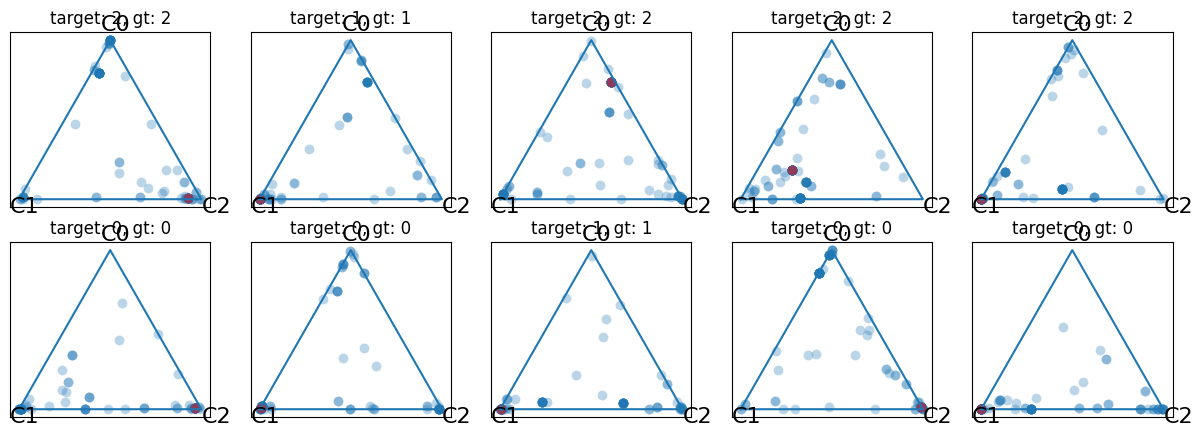

In [23]:
import numpy.random as nprn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.special import softmax

fig = plt.figure(figsize = (15, 5))

for idx in range(10):
    # row = df_noisy.iloc[idx]
    row = df_clean.iloc[idx]
    raw_data = row['output'].div(1).softmax(-1).numpy()
    pointpred = row['pointpred'].softmax(-1).numpy()

    p1 = np.array([0.0, (3.0**0.5) - 1.0])
    p2 = np.array([-1.0, -1.0])
    p3 = np.array([1.0, -1.0])


    # add subplot
    ax = fig.add_subplot(2, 5, idx+1)
    plt.plot([-1.0, 1.0, 0.0, -1.0], [-1.0, -1.0, (3.0**0.5) - 1.0, -1.0])

    points = []
    for t1, t2, t3 in raw_data:
        points.append(p1 * t1 + p2 * t2 + p3 * t3)
    points = np.array(points)

    plt.scatter(points.T[0], points.T[1] , edgecolors = '#ffffff', alpha = 0.3, s=50, linewidth=0)

    pointpred = (p1 * pointpred[0] + p2 * pointpred[1] + p3 * pointpred[2])
    plt.scatter([pointpred[0]], [pointpred[1]], color='red', alpha = 0.5, s=50, linewidth=0)

    plt.title(f"target: {row['target']}, gt: {row['target_gt']}")

    plt.text(p1[0]-0.1, p1[1]+0.1, 'C0', fontsize = 16)
    plt.text(p2[0]-0.1, p2[1]-0.15, 'C1', fontsize = 16)
    plt.text(p3[0], p3[1]-0.15, 'C2', fontsize = 16)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [68]:
df_noisy

,output,is_noisy,target,target_gt
0,"[[tensor(-2.2860), tensor(1.7956), tensor(-4.7...",True,5,6
4,"[[tensor(-1.4844), tensor(9.8847), tensor(2.01...",True,9,1
6,"[[tensor(-5.1203), tensor(-6.1005), tensor(11....",True,5,2
7,"[[tensor(1.2945), tensor(0.7255), tensor(-5.62...",True,8,7
9,"[[tensor(9.1273), tensor(-6.4233), tensor(3.41...",True,0,3
...,...,...,...,...
49987,"[[tensor(8.5651), tensor(-2.0810), tensor(0.51...",True,0,2
49988,"[[tensor(2.3920), tensor(1.0641), tensor(1.627...",True,2,5
49990,"[[tensor(-5.3796), tensor(-2.4155), tensor(2.1...",True,6,4
49998,"[[tensor(-3.2836), tensor(9.1739), tensor(-5.4...",True,8,1


In [59]:
torch.set_printoptions(sci_mode=False)

In [ ]:
idx = 1

In [99]:
df_clean.iloc[idx,0].div(4).softmax(-1)

tensor([[0.0521, 0.0135, 0.0812, 0.0436, 0.0673, 0.0241, 0.0276, 0.6106, 0.0403,
         0.0398],
        [0.0079, 0.0201, 0.0313, 0.0073, 0.0278, 0.0104, 0.0031, 0.7926, 0.0746,
         0.0250],
        [0.0913, 0.0827, 0.0202, 0.0177, 0.1704, 0.1139, 0.0138, 0.3438, 0.1306,
         0.0156],
        [0.0211, 0.0095, 0.0209, 0.0054, 0.0357, 0.0220, 0.0041, 0.7500, 0.1147,
         0.0165],
        [0.0279, 0.0932, 0.0823, 0.0152, 0.1003, 0.1138, 0.0128, 0.2541, 0.0600,
         0.2406],
        [0.1348, 0.0392, 0.0794, 0.0260, 0.0293, 0.0323, 0.0765, 0.0448, 0.0073,
         0.5304],
        [0.1370, 0.0050, 0.0120, 0.0017, 0.0644, 0.0549, 0.0434, 0.5418, 0.1061,
         0.0338],
        [0.0079, 0.0201, 0.0313, 0.0073, 0.0278, 0.0104, 0.0031, 0.7926, 0.0746,
         0.0250],
        [0.0913, 0.0827, 0.0202, 0.0177, 0.1704, 0.1139, 0.0138, 0.3438, 0.1306,
         0.0156],
        [0.0211, 0.0095, 0.0209, 0.0054, 0.0357, 0.0220, 0.0041, 0.7500, 0.1147,
         0.0165]])

In [88]:
df_clean.iloc[idx,0].argmax(-1)

tensor([7, 7, 7, 7, 7, 9, 7, 7, 7, 7])

In [95]:
df_clean.iloc[idx,2]

7

In [98]:
df_noisy.iloc[idx,0].div(4).softmax(-1)

tensor([[0.1221, 0.0701, 0.0207, 0.3374, 0.0817, 0.0738, 0.1362, 0.0562, 0.0223,
         0.0793],
        [0.0656, 0.0159, 0.1466, 0.2190, 0.0077, 0.0561, 0.1686, 0.1241, 0.0619,
         0.1344],
        [0.9032, 0.0016, 0.0016, 0.0190, 0.0070, 0.0022, 0.0388, 0.0119, 0.0039,
         0.0109],
        [0.9063, 0.0020, 0.0016, 0.0228, 0.0072, 0.0025, 0.0310, 0.0114, 0.0038,
         0.0113],
        [0.1221, 0.0701, 0.0207, 0.3374, 0.0817, 0.0738, 0.1362, 0.0562, 0.0223,
         0.0793],
        [0.1221, 0.0701, 0.0207, 0.3374, 0.0817, 0.0738, 0.1362, 0.0562, 0.0223,
         0.0793],
        [0.7474, 0.0025, 0.0186, 0.0082, 0.0341, 0.0035, 0.1072, 0.0111, 0.0042,
         0.0633],
        [0.4065, 0.0157, 0.0102, 0.0764, 0.0090, 0.0049, 0.4024, 0.0112, 0.0162,
         0.0474],
        [0.1053, 0.0438, 0.0084, 0.3466, 0.0189, 0.0069, 0.2555, 0.0179, 0.0045,
         0.1923],
        [0.0710, 0.0169, 0.2186, 0.0649, 0.1990, 0.3162, 0.0075, 0.0416, 0.0169,
         0.0475]])

In [90]:
df_noisy.iloc[idx,0].argmax(-1)

tensor([3, 3, 0, 0, 3, 3, 0, 0, 3, 5])

In [92]:
df_noisy.iloc[idx,2]

0

In [80]:
df_noisy['output'].apply(lambda x: x.argmax(-1).tolist())

0        [5, 2, 5, 9, 4, 3, 3, 5, 5, 5]
4        [1, 9, 9, 9, 9, 9, 9, 5, 2, 9]
6        [2, 2, 2, 7, 2, 5, 0, 2, 5, 5]
7        [7, 7, 9, 7, 8, 8, 8, 8, 7, 7]
9        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      ...              
49987    [0, 0, 5, 0, 5, 5, 0, 0, 0, 0]
49988    [0, 2, 2, 2, 2, 2, 9, 8, 2, 9]
49990    [6, 6, 9, 6, 6, 6, 6, 6, 6, 6]
49998    [1, 6, 1, 8, 8, 8, 8, 1, 1, 1]
49999    [1, 1, 1, 3, 3, 3, 0, 3, 3, 3]
Name: output, Length: 19825, dtype: object

In [81]:
df_noisy[['target', 'target_gt']]

,target,target_gt
0,5,6
4,9,1
6,5,2
7,8,7
9,0,3
...,...,...
49987,0,2
49988,2,5
49990,6,4
49998,8,1


In [4]:
temperatures

array([0.35277528, 0.36352417, 0.3177086 , 0.28579813, 0.4060483 ],
      dtype=float32)

In [5]:
x

array([[1.38113514e-01, 7.35828478e-04, 9.21101719e-02, 9.95179862e-02,
        3.52775276e-01, 2.29577273e-01, 1.07949032e-02, 7.63510615e-02,
        2.38470184e-05, 1.46615690e-07],
       [2.87728608e-01, 6.46307413e-03, 1.34178489e-01, 3.30665894e-02,
        7.59614259e-02, 3.63524169e-01, 2.67706998e-02, 3.46248178e-03,
        6.74435345e-04, 6.81700334e-02],
       [7.69308284e-02, 5.36913976e-05, 1.38955731e-02, 1.63167287e-02,
        2.05964908e-01, 3.17708611e-01, 2.40940467e-01, 2.44701579e-02,
        9.02634189e-02, 1.34556005e-02],
       [1.85017109e-01, 4.75987617e-04, 2.42270697e-02, 1.03126831e-05,
        1.02085970e-01, 2.85798132e-01, 8.58499184e-02, 6.20583370e-02,
        3.46262823e-07, 2.54476815e-01],
       [9.87400413e-02, 4.57317978e-02, 1.66084599e-02, 1.04095116e-02,
        1.66996256e-01, 4.06048298e-01, 8.40244442e-02, 1.34008363e-01,
        3.70526873e-02, 3.80152196e-04]], dtype=float32)

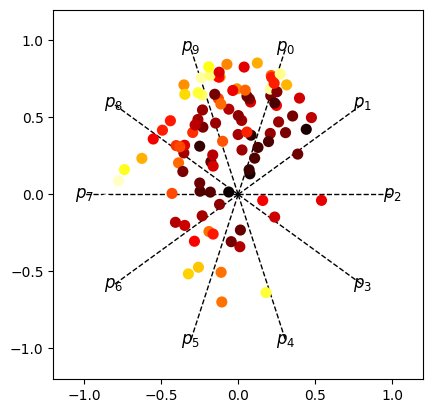

In [10]:
import numpy as np
import torch

def get_projection_matrix(k):
    theta = (2*np.pi/k) * (np.arange(k) + 0.5)
    return np.stack([np.sin(theta), np.cos(theta)], axis=0)

num_classes = 10
T = get_projection_matrix(num_classes)

x = torch.distributions.dirichlet.Dirichlet(torch.rand(num_classes)).sample((100,)).numpy()
points = T @ x.T



import matplotlib.pyplot as plt

# Define the vertices of the octagon
vertices = T @ np.eye(num_classes)
vertices = np.hstack([vertices, vertices[:, 0:1]])

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the octagon
# ax.plot(vertices[0], vertices[1], color='black', linewidth=2)
for i, vertex in enumerate(vertices[:,:-1].T):
    ax.text(vertex[0], vertex[1], f"$p_{i}$", ha='center', va='center', fontsize=12)
    ax.plot([0, vertex[0]], [0, vertex[1]], 'k--', linewidth=1)

# Plot the points
temperatures = [15, 20, 25, 30, 35, 30, 25, 20][:5]
temperatures = x.max(-1)
ax.scatter(points[0], points[1], linewidth=2, zorder=10, c=temperatures, cmap='hot')

# Set the axis limits
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')


# Show the plots
plt.show()

In [34]:
x.shape

(100, 3)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 10)

<Figure size 2500x1000 with 0 Axes>

In [17]:
points_3d

array([[3.6775550e-01, 6.2561661e-01, 6.6278689e-03],
       [5.2070100e-02, 1.4358385e-01, 8.0434602e-01],
       [4.7368643e-01, 4.8702164e-03, 5.2144337e-01],
       [7.6561131e-02, 4.0714018e-04, 9.2303175e-01],
       [6.7469025e-01, 3.2530972e-01, 1.7906617e-08]], dtype=float32)

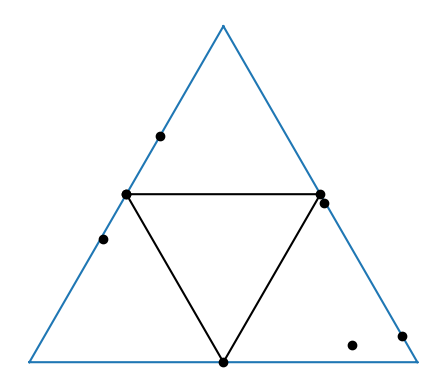

In [16]:
from __future__ import division
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri


def project_3d_to_simplex(points_ndarray):
    x = np.empty((2, len(points_ndarray)))
    x[:] = \
        (points_ndarray[:, 0] + 2*points_ndarray[:, 2])*sqrt(3)/3, \
        points_ndarray[:, 0]
    return x


# points_3d = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1/3, 1/3, 1/3]])
points_3d = torch.distributions.dirichlet.Dirichlet(torch.rand(3)).sample((5,)).numpy()
points_simplex = project_3d_to_simplex(points_3d)

points2_3d = np.array([[1/2, 1/2, 0], [0, 1/2, 1/2], [1/2, 0, 1/2], [1/2, 1/2, 0]])
points2_simplex = project_3d_to_simplex(points2_3d)


vertices= np.array([[sqrt(3)/3, 1], [0, 0], [2*sqrt(3)/3, 0]])
triangle = tri.Triangulation(vertices[:, 0], vertices[:, 1])

fig, ax = plt.subplots()
ax.triplot(triangle)
ax.set_axis_off()
# ax.set_xlim(0, 2*sqrt(3)/3)
# ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.scatter(points_simplex[0], points_simplex[1], c='black')
ax.scatter(points2_simplex[0], points2_simplex[1], c='black')
ax.plot(points2_simplex[0], points2_simplex[1], c='black')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

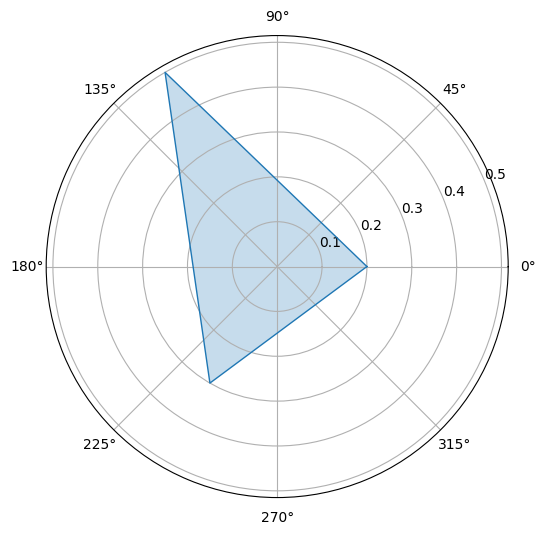

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(probability_vectors, class_labels):
    num_classes = len(class_labels)
    angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for probability_vector in probability_vectors:
        values = probability_vector
        values += values[:1]  # Repeat the first value to close the polygon
        angles += angles[:1]  # Repeat the first angle to close the polygon
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), class_labels)

    ax.set_ylim(0, 1)
    plt.show()

# Example probability vectors
probability_vectors = [
    [0.2, 0.5, 0.3],
    [0.7, 0.1, 0.2],
    [0.3, 0.3, 0.4]
]

# Example class labels
class_labels = ['Class A', 'Class B', 'Class C']

plot_radar_chart(probability_vectors, class_labels)


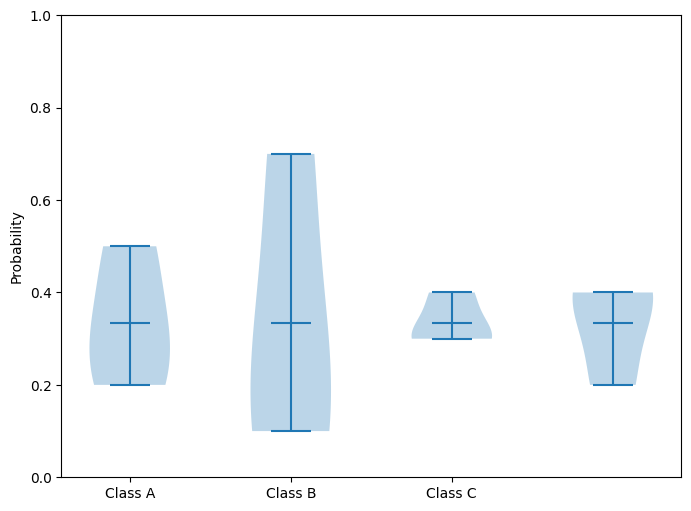

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_violin_plot(probability_vectors, class_labels):
    num_classes = len(class_labels)
    
    # Transpose the probability_vectors
    transposed_vectors = np.transpose(probability_vectors)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.violinplot(transposed_vectors, showmeans=True, showmedians=False)

    ax.set_xticks(range(1, num_classes + 1))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)

    plt.show()

# Example probability vectors
probability_vectors = [
    [0.2, 0.5, 0.3],
    [0.7, 0.1, 0.2],
    [0.3, 0.3, 0.4],
    [0.4, 0.4, 0.2]
]

# Example class labels
class_labels = ['Class A', 'Class B', 'Class C']

plot_violin_plot(probability_vectors, class_labels)


In [21]:
!pip install python-ternary

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


/home/user/.local/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


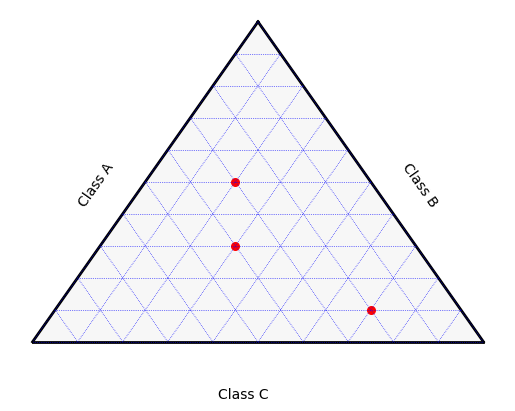

In [22]:
import ternary
import matplotlib.pyplot as plt

def plot_ternary_plot(probability_vectors, class_labels):
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=0.1, color="blue")
    
    # Plot the probability vectors
    for probability_vector in probability_vectors:
        tax.scatter([probability_vector], marker='o', color='red', s=30)

    # Set the labels
    tax.left_axis_label(class_labels[0], fontsize=10, offset=0.12)
    tax.right_axis_label(class_labels[1], fontsize=10, offset=0.12)
    tax.bottom_axis_label(class_labels[2], fontsize=10, offset=0.12)

    # Remove the default Matplotlib axis
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    plt.show()

# Example probability vectors
probability_vectors = [
    [0.2, 0.5, 0.3],
    [0.7, 0.1, 0.2],
    [0.3, 0.3, 0.4]
]

# Example class labels
class_labels = ['Class A', 'Class B', 'Class C']

plot_ternary_plot(probability_vectors, class_labels)


## perturbation-based filtering

In [3]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        losses = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified


KeyboardInterrupt: 

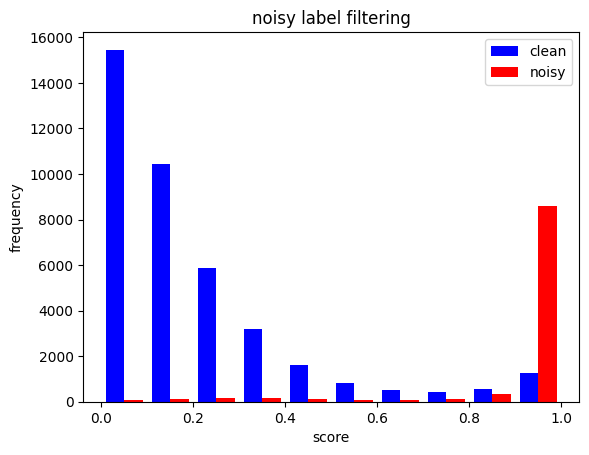

0.9691574631369061


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = result['loss']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
# score = result['std']

blue_data = score[~result['is_noisy']]
red_data = score[result['is_noisy']]
auroc = roc_auc_score(is_noisy, score)

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}", transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

## Loss magnitude based filtering (single forward pass)

In [3]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'loss': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        data = transform_normalize(data)
        output = trainer.model(data)
        loss = trainer.criterion(output, target)
        is_noisy = (target != target_gt)
        result['loss'].append(loss)
        result['is_noisy'].append(is_noisy)

    result['loss'] = torch.cat(result['loss'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'loss': tensor([9.9999e-01, 0.0000e+00, 2.3842e-06,  ..., 2.5922e-04, 1.0000e+00,
        9.9999e-01])}


In [4]:
result['loss']

tensor([9.9999e-01, 0.0000e+00, 2.3842e-06,  ..., 2.5922e-04, 1.0000e+00,
        9.9999e-01])

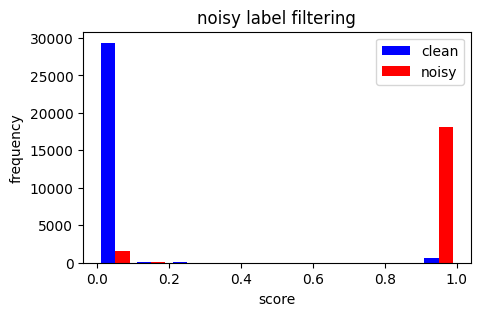

AUROC: 0.9733149005747264


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = result['loss']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
# score = result['std']

blue_data = score[~result['is_noisy']]
red_data = score[result['is_noisy']]
auroc = roc_auc_score(is_noisy, score)

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}", transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

## perturbation-based filtering by estimating dirichlet distribution

In [38]:
# perturbation-based filtering
# for estimating dirichlet distribution entropy

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = {
        'logit': [],
        'loss': [],
        'target': [],
        'target_gt': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        result = {
            'logit': [],
            'loss': [],
        }
        for _ in range(100):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            result['logit'].append(output)
            result['loss'].append(loss)
        result['logit'] = torch.stack(result['logit'], dim=-2)
        result['loss'] = torch.stack(result['loss'], dim=-1)
        results['logit'].append(result['logit'])
        results['loss'].append(result['loss'])
        results['target'].append(target)
        results['target_gt'].append(target_gt)

    results['logit'] = torch.cat(results['logit'], dim=0).cpu()
    results['loss'] = torch.cat(results['loss'], dim=0).cpu()
    results['target'] = torch.cat(results['target'], dim=0).cpu()
    results['target_gt'] = torch.cat(results['target_gt'], dim=0).cpu()


pprint.pprint(results)

Files already downloaded and verified
{'logit': tensor([[[ -2.1602,   2.0157,  -4.9380,  ...,  -2.5221,  -1.2355,  -5.9756],
         [  4.9457,   3.4917,  -7.9251,  ...,   1.5963,  -3.9554,   3.6843],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016],
         ...,
         [ -4.1058,   6.6168,  -0.1880,  ...,  -3.4171,  -3.8254,  -3.2090],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016],
         [ -2.2870,   1.7951,  -4.7126,  ...,  -1.9573,  -1.6994,  -6.5016]],

        [[  8.2736,   5.2546, -13.8468,  ...,  -4.9621,   2.5193,  20.0269],
         [ -2.5532,  -3.8122,   0.4225,  ...,   9.1137,   1.5777,  -0.5117],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337],
         ...,
         [  3.3617,   0.3426, -14.4359,  ...,  -0.9384,   4.3554,  14.7326],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337],
         [  7.7221,   5.6024, -13.5597,  ...,  -5.6003,   2.1162,  20.0337]

In [39]:
# save intermediate results in case of crash
torch.save(results, "results.pt")

### Dirichlet parameter estimation algorithms

In [41]:
# MLE algorithm implemented in https://github.com/ericsuh/dirichlet
import numpy
import dirichlet

alpha = numpy.array([100, 299, 1e-2, 14, 201, 449, 129])
data = numpy.random.dirichlet(alpha, 10)

alpha_hat = dirichlet.mle(data)
alpha_hat

array([1.67163339e+02, 4.85508291e+02, 7.06412649e-03, 2.39601016e+01,
       3.29187602e+02, 7.25486795e+02, 2.14350016e+02])

In [42]:
dirichlet.mle(data, method='fixedpoint')

array([0.08627898, 0.09559537, 0.08429229, 0.07852801, 0.08049584,
       0.06059681, 0.07419641, 0.05203358, 0.1400893 , 0.35771788])

In [25]:
# MLE algorithm implemented using PyTorch L-BFGS
import torch

def fit_dirichlet_pytorch(data):
    k = data.shape[-1]
    param = torch.rand((k,), dtype=data.dtype, requires_grad=True)
    dirichlet = torch.distributions.dirichlet.Dirichlet(param)

    optimizer = torch.optim.LBFGS([param], lr=0.001, max_iter=20, line_search_fn='strong_wolfe')

    def closure():
        optimizer.zero_grad()
        loss = - dirichlet.log_prob(data).sum()
        loss.backward()
        return loss

    for _ in range(10):
        optimizer.step(closure)

    return param.detach()


alpha = torch.tensor([10.0, 1.0, 5.0, 1.0])
data = torch.distributions.dirichlet.Dirichlet(alpha).sample((100,))

alpha_hat = fit_dirichlet_pytorch(data)

In [34]:
fit_dirichlet_pytorch(results['logit'].to(torch.float64).softmax(-1).unbind()[9])

tensor([1.6271, 0.0838, 0.0845, 0.1509, 0.0740, 0.1164, 0.0862, 0.0763, 0.0814,
        0.1411], dtype=torch.float64)

In [130]:
is_noisy[:10]

array([ True, False, False, False,  True, False,  True,  True, False,
        True])

In [14]:
# results['logit'].to(torch.float64).softmax(-1).shape
results['logit'].to(torch.float64).softmax(-1).unbind()[0].shape

torch.Size([10, 10])

In [9]:
results['logit'].to(torch.float64).softmax(-1).shape

torch.Size([50000, 10, 10])

In [35]:
from tqdm.contrib.concurrent import process_map  # or thread_map

items = results['logit'].to(torch.float64).softmax(-1).unbind(0)
processed_items = process_map(fit_dirichlet_pytorch, items, max_workers=10)

/tmp/ipykernel_55990/3929253804.py:4: TqdmWarning: Iterable length 50000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  processed_items = process_map(fit_dirichlet_pytorch, items, max_workers=10)


  0%|          | 0/50000 [00:00<?, ?it/s]

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [39]:
import multiprocess as mp
# from torch.multiprocessing import Pool


items = results['logit'].to(torch.float64).softmax(-1).unbind(0)

ctx = mp.get_context('spawn')
with ctx.Pool(10) as pool:
    processed_items = pool.map(fit_dirichlet_pytorch, items)

In [36]:
import torch.multiprocessing as mp
# from torch.multiprocessing import Pool


items = results['logit'].to(torch.float64).softmax(-1).unbind(0)

ctx = mp.get_context('spawn')
with ctx.Pool(10) as pool:
    processed_items = pool.map(fit_dirichlet_pytorch, items)

Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'fit_dirichlet_pytorch' on <module '__main__' (built-in)>
Process SpawnPoolWorker-16:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/

KeyboardInterrupt: 

In [57]:
# MLE algorithm implemented using SciPy L-BFGS

import numpy as np
from scipy.special import psi, gammaln
from scipy.optimize import minimize
import scipy
import scipy.stats

def dirichlet_log_likelihood(alpha, data):
    n, k = data.shape
    log_likelihood = n * (gammaln(np.sum(alpha)) - np.sum(gammaln(alpha))) + np.sum((alpha - 1) * np.sum(np.log(data), axis=0))
    return -log_likelihood

def dirichlet_gradient(alpha, data):
    n, k = data.shape
    gradient = n * (psi(np.sum(alpha)) - psi(alpha)) + np.sum(np.log(data), axis=0)
    return -gradient

def fit_dirichlet(data, initial_alpha=None):
    data = np.array(data)
    if initial_alpha is None:
        initial_alpha = np.ones(data.shape[1])

    result = minimize(
        dirichlet_log_likelihood, initial_alpha, args=(data),
        jac=dirichlet_gradient, method='L-BFGS-B', bounds=[(1e-6, None) for _ in initial_alpha]
    )

    if result.success:
        return result.x
    else:
        raise ValueError("Failed to fit Dirichlet distribution: " + result.message)


# Example data
alpha = [10.0, 1.0, 5.0, 1.0]
data = scipy.stats.dirichlet(alpha).rvs(1000)
# data = results['logit'].to(torch.double).softmax(-1).numpy()[3]

# Fit the Dirichlet distribution
alpha_hat = fit_dirichlet(data)
print("Estimated alpha parameters:", alpha_hat)


Estimated alpha parameters: [9.68757704 0.97952433 4.97661203 0.98901869]


In [60]:
# import multiprocess as mp
from torch.multiprocessing import Pool

items = results['logit'].to(torch.float64).softmax(-1).unbind(0)
items = [np.array(x) for x in items]

with Pool(1000) as pool:
    processed_items = pool.map(fit_dirichlet, items)

In [72]:
processed_items = np.array(processed_items)
processed_items.shape

(50000, 10)

In [11]:
np.array(processed_items)[0]

array([0.07392509, 0.09778622, 0.07857815, 0.09688988, 0.06868253,
       0.21338689, 0.11196087, 0.07313143, 0.07801399, 0.06190548])

In [49]:
alpha2 = []
for vec in results['logit'].to(torch.double).softmax(-1).numpy():
    alpha2.append(fit_dirichlet(vec))

alpha2 = np.array(alpha2)

In [51]:
alpha2.shape

(50000, 10)

In [13]:
# calculate entropy of Dirichlet distribution

import numpy as np
from scipy.special import gammaln, psi

def dirichlet_entropy(alpha):
    alpha0 = np.sum(alpha)
    k = len(alpha)
    
    log_beta = np.sum(gammaln(alpha)) - gammaln(alpha0)
    entropy = log_beta + (alpha0 - k) * psi(alpha0) - np.sum((alpha - 1) * psi(alpha))
    
    return entropy

def batched_dirichlet_entropy(alpha):
    b, k = alpha.shape
    alpha0 = np.sum(alpha, axis=1)
    
    log_beta = np.sum(gammaln(alpha), axis=1) - gammaln(alpha0)
    entropy = log_beta + (alpha0 - k) * psi(alpha0) - np.sum((alpha - 1) * psi(alpha), axis=1)
    
    return entropy

# Example usage
alpha = np.array([3, 5, 2])
entropy = dirichlet_entropy(alpha)
print("Entropy of the Dirichlet distribution:", entropy)

# Example usage
alpha = np.array([3, 5, 2])[np.newaxis, :].repeat(10, axis=0)
entropy = batched_dirichlet_entropy(alpha)
print("Entropy of the Dirichlet distribution:", entropy)


Entropy of the Dirichlet distribution: -1.4611820247291334
Entropy of the Dirichlet distribution: [-1.46118202 -1.46118202 -1.46118202 -1.46118202 -1.46118202 -1.46118202
 -1.46118202 -1.46118202 -1.46118202 -1.46118202]


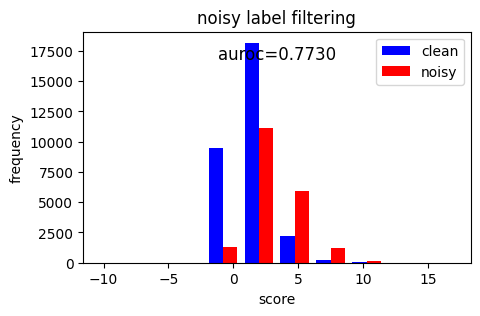

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

score = entropy
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)
blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

In [48]:
print(entropy.min(), entropy.max())

-10494451000000.0 -75.583466


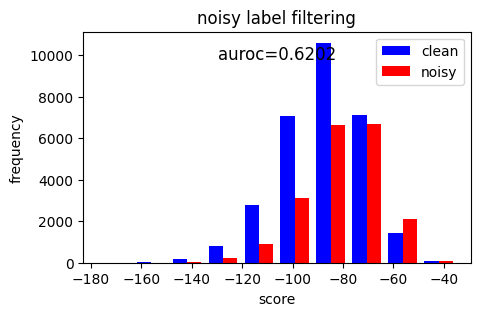

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

entropy = batched_dirichlet_entropy(processed_items)

score = entropy
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()


## fixed perturbation-based filtering

현재 메소드는 perturbed prediction 간의 disagreement 를 측정하고 있는데, 이게 아니라 unperturbed prediction vs. perturbed prediction 간의 disagreement 를 측정하는게 더 좋을 것 같다.

In [77]:
# perturbation-based filtering
# for estimating dirichlet distribution entropy

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torch.nn.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = {
        'kldiv': [],
        'target': [],
        'target_gt': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        pred = trainer.model(transform_normalize(data)).softmax(dim=-1)

        ensemble = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            ensemble.append(output.softmax(dim=-1))
        ensemble = torch.stack(ensemble, dim=0).mean(0)

        results['kldiv'].append(F.kl_div(pred, ensemble, reduction='none').sum(1))
        results['target'].append(target)
        results['target_gt'].append(target_gt)

    results['kldiv'] = torch.cat(results['kldiv'], dim=0).cpu()
    results['target'] = torch.cat(results['target'], dim=0).cpu()
    results['target_gt'] = torch.cat(results['target_gt'], dim=0).cpu()


pprint.pprint(results)

Files already downloaded and verified
{'kldiv': tensor([[-1.8653e-02, -4.5042e-02, -3.6516e-01,  ..., -1.2719e-03,
         -1.3116e-01, -2.2392e-01],
        [-5.9909e-02, -1.1275e-02, -9.5148e-02,  ..., -1.5345e-01,
         -1.0603e-01, -9.9113e-01],
        [-2.6669e-01, -1.5503e-01, -1.6335e-01,  ..., -1.2745e-02,
         -3.2046e-01, -8.5889e-01],
        ...,
        [-4.4421e-02, -3.0599e-03, -2.4050e-01,  ..., -1.3455e-03,
         -1.1923e-01, -9.8478e-01],
        [-5.9184e-03, -4.0437e-01, -4.1164e-04,  ..., -1.9883e-01,
         -7.3964e-01, -4.4795e-02],
        [-2.4039e-01, -2.2092e-01, -2.2241e-02,  ..., -2.2393e-01,
         -2.6908e-03, -3.3409e-03]]),
 'target': tensor([5, 9, 9,  ..., 9, 8, 3]),
 'target_gt': tensor([6, 9, 9,  ..., 9, 1, 1])}


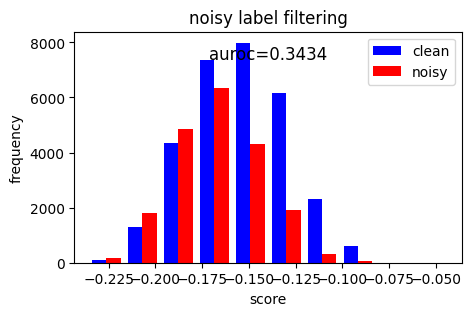

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


score = results['kldiv']
is_noisy = (results['target'] != results['target_gt']).numpy()

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')

ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

# add title and axis labels
ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")


# add legend
ax.legend()

# display the histogram
plt.show()


## AUROC per training epoch

In [ ]:
def load_checkpoint(name="model_199.pth"):
    checkpoint = wandb.restore(name, run_path=f"siit-iitp/noisy-label/{WANDB_RUN_ID}", replace=True)
    model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))

In [ ]:
# perturbation-based filtering

from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F



transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train



with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    results = []

    for ep in range(9, 200, 10):
        load_checkpoint(f"model_{ep}.pth")

        result = {
            'loss': [],
            'std': [],
            'mean': [],
            'is_noisy': [],
        }
        for batch in dataloader:
            data, target = batch["image"].cuda(), batch["target"].cuda()
            target_gt = batch["target_gt"].cuda()

            data_ = transform_normalize(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            result['loss'].append(loss)

            losses = []
            for _ in range(10):
                # data_ = torch.normal(transform_normalize(data), 0.1)
                data_ = transform_tta(data)
                output = trainer.model(data_)
                loss = trainer.criterion(output, target)
                losses.append(loss)
            std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
            is_noisy = (target != target_gt)
            result['std'].append(std)
            result['mean'].append(mean)
            result['is_noisy'].append(is_noisy)

        result['std'] = torch.cat(result['std'], dim=0).cpu()
        result['mean'] = torch.cat(result['mean'], dim=0).cpu()
        result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()
        results.append(result)

pprint.pprint(result)

In [ ]:
# save intermediate results in case of crash
torch.save(results, "./test-time.pth")

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

temp = []
for result in results:
    temp.append({
        'loss': roc_auc_score(result['is_noisy'], result['loss']),
        'loss mean': roc_auc_score(result['is_noisy'], result['mean']),
        'mean + 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] + 0.5*result['std']),
        'mean - 0.5*std': roc_auc_score(result['is_noisy'], result['mean'] - 0.5*result['std']),
        'std': roc_auc_score(result['is_noisy'], result['std']),
    })

temp = pd.DataFrame(temp)
temp['epoch'] = list(range(9,200,10))
temp = temp.set_index('epoch')
temp

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = temp

fig, ax = plt.subplots()
df.plot(ax=ax)

ax.set_xlabel('epoch')
ax.set_ylabel('filtering performance (AUROC)')
plt.show()


## Latent-space perturbation

In [ ]:
from models import MCDropout, GaussianMCDropout

# dropout = MCDropout
dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))

In [ ]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        losses = []
        for _ in range(10):
            data_ = transform_normalize(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()


### use both MC dropout and input perturbation

In [ ]:
from models import MCDropout, GaussianMCDropout

dropout = MCDropout
# dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))




# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset, _ = datasets.get_dataset(**config["data"])
train_dataset.transform = transform_train


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].cuda(), batch["target"].cuda()
        target_gt = batch["target_gt"].cuda()
        losses = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])

ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")
ax.legend()
plt.show()
